In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [3]:
model = "deepseek-r1-distill-llama-70b"

In [4]:
from langchain_groq import ChatGroq

In [5]:
llm = ChatGroq(model=model)

In [6]:
llm.invoke("Hey, what's the weather like in SF?")

AIMessage(content="<think>\n\n</think>\n\nHi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 13, 'total_tokens': 47, 'completion_time': 0.212753428, 'prompt_time': 0.000445725, 'queue_time': 0.21980403199999998, 'total_time': 0.213199153}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--a25a0e21-a23b-4939-a697-3e9c8f180556-0', usage_metadata={'input_tokens': 13, 'output_tokens': 34, 'total_tokens': 47})

In [7]:
import operator
from typing import List
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langgraph.graph.message import add_messages
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langgraph.graph import END, StateGraph, MessagesState, START
from pydantic import BaseModel, Field

In [8]:
def call_model(state):
    message = state["messages"]
    response = llm.invoke(message)
    return {"messages": [response]}

In [9]:
state = {"messages":["Hey, what's the weather like in SF?"]}

In [10]:
call_model(state)

{'messages': [AIMessage(content="<think>\n\n</think>\n\nHi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 13, 'total_tokens': 47, 'completion_time': 0.209516883, 'prompt_time': 0.000429575, 'queue_time': 0.219609827, 'total_time': 0.209946458}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--58b06cbe-1f42-4ea9-85ac-3e1f5da9513c-0', usage_metadata={'input_tokens': 13, 'output_tokens': 34, 'total_tokens': 47})]}

In [11]:
workflow = StateGraph(MessagesState)

In [12]:
workflow.add_node("mybot", call_model)
workflow.add_edge(START, "mybot")

In [13]:
workflow.add_edge("mybot",END)

In [14]:
app = workflow.compile()

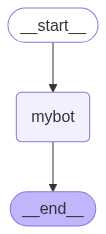

In [15]:
from IPython.display import display, Image
display(Image(app.get_graph().draw_mermaid_png()))

In [16]:
input = {"messages": ["Hey, what's the weather like in SF?"]}

In [17]:
app.invoke(input)

{'messages': [HumanMessage(content="Hey, what's the weather like in SF?", additional_kwargs={}, response_metadata={}, id='ec596208-4031-4471-916f-e3f7c6e6dc17'),
  AIMessage(content="<think>\n\n</think>\n\nHi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 13, 'total_tokens': 47, 'completion_time': 0.205394878, 'prompt_time': 0.000421955, 'queue_time': 0.218772637, 'total_time': 0.205816833}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--0786a1cd-c578-4a20-8c5f-2f594922118f-0', usage_metadata={'input_tokens': 13, 'output_tokens': 34, 'total_tokens': 47})]}

In [18]:
for output in app.stream(input):
    for key, value in output.items():
        print(f"{key}: {value}")

mybot: {'messages': [AIMessage(content="<think>\n\n</think>\n\nHi there! I suggest getting online to get real-time information. If you have any other questions, please don't hesitate to let me know!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 13, 'total_tokens': 47, 'completion_time': 0.208584562, 'prompt_time': 0.000410745, 'queue_time': 0.218566007, 'total_time': 0.208995307}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--07e8120e-d525-48fb-bfee-48f5facf6a22-0', usage_metadata={'input_tokens': 13, 'output_tokens': 34, 'total_tokens': 47})]}


In [19]:
from langchain_core.tools import tool

@tool
def search(query: str):
    """Searches the web for a query and returns the top result."""
    if "mumbai" in query.lower():
        return "Temperature in Mumbai is 30°C with high humidity."
    
    return "IDK"

In [20]:
search.invoke("What is the temperature in Kashmir?")

'IDK'

In [21]:
search.invoke("What is the temperature in Mumbai?")

'Temperature in Mumbai is 30°C with high humidity.'

In [22]:
tools = [search]
llm_with_tool = llm.bind_tools(tools)

In [23]:
response = llm_with_tool.invoke("What is the temperature in Mumbai?")

In [24]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'temperature in Mumbai'},
  'id': 'y0rnm10as',
  'type': 'tool_call'}]

In [25]:
def call_model(state: MessagesState):
    question = state['messages']
    response = llm_with_tool.invoke(question)
    return {"messages": [response]}

In [26]:
call_model(input)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'g9c4kcmtz', 'function': {'arguments': '{"query":"San Francisco weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 166, 'prompt_tokens': 138, 'total_tokens': 304, 'completion_time': 0.786312537, 'prompt_time': 0.009045779, 'queue_time': 0.218158992, 'total_time': 0.795358316}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--aa6f035a-7d49-4d1d-be89-12acd2da58e3-0', tool_calls=[{'name': 'search', 'args': {'query': 'San Francisco weather'}, 'id': 'g9c4kcmtz', 'type': 'tool_call'}], usage_metadata={'input_tokens': 138, 'output_tokens': 166, 'total_tokens': 304})]}

In [27]:
def router_function(state:MessagesState):
    message = state["messages"]
    last_message = message[-1]
    
    if last_message.tool_calls:
        return "tools"
    return END

In [28]:
from langgraph.prebuilt import ToolNode

In [29]:
tool_node = ToolNode(tools)

In [30]:
workflow2 = StateGraph(MessagesState)
workflow2.add_node("llmwithnode",call_model)
workflow2.add_node("mytools",tool_node)

In [31]:
workflow2.add_edge(START,"llmwithnode")

workflow2.add_conditional_edges("llmwithnode", router_function, {
    "tools": "mytools",
    END: END
})

In [32]:
app2 = workflow2.compile()

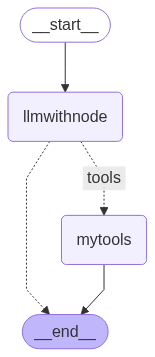

In [33]:
display(Image(app2.get_graph().draw_mermaid_png()))

In [34]:
app2.invoke({"messages":["What is the temperature in Mumbai?"]})

{'messages': [HumanMessage(content='What is the temperature in Mumbai?', additional_kwargs={}, response_metadata={}, id='1fc09e8e-40cd-4049-acdf-13d3531129a2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'zwbeq8022', 'function': {'arguments': '{"query":"temperature in Mumbai"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 266, 'prompt_tokens': 135, 'total_tokens': 401, 'completion_time': 1.196178248, 'prompt_time': 0.008669043, 'queue_time': 0.219806729, 'total_time': 1.204847291}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2754c772-3c61-4a82-acb9-a97761fafbb0-0', tool_calls=[{'name': 'search', 'args': {'query': 'temperature in Mumbai'}, 'id': 'zwbeq8022', 'type': 'tool_call'}], usage_metadata={'input_tokens': 135, 'output_tokens': 266, 'total_tokens': 401}),
  ToolMessage(content='Temperature in Mumbai is 30°C

In [35]:
app2.invoke({"messages":["What is the temperature in Delhi?"]})

{'messages': [HumanMessage(content='What is the temperature in Delhi?', additional_kwargs={}, response_metadata={}, id='bae62b1b-f06d-4d3f-908d-ef6d84357ceb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'pnak7dpqb', 'function': {'arguments': '{"query":"temperature in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 62, 'prompt_tokens': 135, 'total_tokens': 197, 'completion_time': 0.305713285, 'prompt_time': 0.008761832, 'queue_time': 0.21964248, 'total_time': 0.314475117}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--fe7f43a8-5aa4-4bdd-9e62-621d7ac788e8-0', tool_calls=[{'name': 'search', 'args': {'query': 'temperature in Delhi'}, 'id': 'pnak7dpqb', 'type': 'tool_call'}], usage_metadata={'input_tokens': 135, 'output_tokens': 62, 'total_tokens': 197}),
  ToolMessage(content='IDK', name='search', id='14f4e217-a

In [36]:
workflow2.add_edge("mytools","llmwithnode")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [37]:
app3 = workflow2.compile()

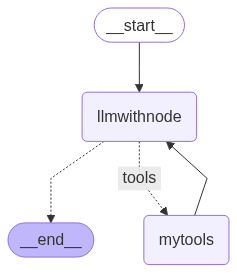

In [38]:
display(Image(app3.get_graph().draw_mermaid_png()))

In [39]:
for output in app3.stream({"messages":["What is the temperature in Mumbai?"]}):
    for key, value in output.items():
        print(f"{key}: {value}")

llmwithnode: {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gk9xfedx8', 'function': {'arguments': '{"query":"temperature in Mumbai"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 103, 'prompt_tokens': 135, 'total_tokens': 238, 'completion_time': 0.556564454, 'prompt_time': 0.009553753, 'queue_time': 0.228714038, 'total_time': 0.566118207}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d45451d2-47a6-4d0b-b851-caa80f809aa0-0', tool_calls=[{'name': 'search', 'args': {'query': 'temperature in Mumbai'}, 'id': 'gk9xfedx8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 135, 'output_tokens': 103, 'total_tokens': 238})]}
mytools: {'messages': [ToolMessage(content='Temperature in Mumbai is 30°C with high humidity.', name='search', id='7c3b30a5-c4d9-4202-9c29-b0b0d711e2dc', tool_call_id='gk9xfedx8')]}
llmwi

In [40]:
for output in app3.stream({"messages":["What is the temperature in Delhi? Also, recommend me some good hotels to stay in Delhi for a week."]}):
    for key, value in output.items():
        print(f"{key}: {value}")

llmwithnode: {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '90qdnfg7p', 'function': {'arguments': '{"query":"current temperature in Delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 288, 'prompt_tokens': 150, 'total_tokens': 438, 'completion_time': 1.2599137950000001, 'prompt_time': 0.018226885, 'queue_time': 0.21764856600000002, 'total_time': 1.27814068}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7a3adb44-5e86-4e80-b0c5-d952a749c57f-0', tool_calls=[{'name': 'search', 'args': {'query': 'current temperature in Delhi'}, 'id': '90qdnfg7p', 'type': 'tool_call'}], usage_metadata={'input_tokens': 150, 'output_tokens': 288, 'total_tokens': 438})]}
mytools: {'messages': [ToolMessage(content='IDK', name='search', id='7eff46d1-1cfe-4d5d-9e16-5725a452cbb5', tool_call_id='90qdnfg7p')]}
llmwithnode: {'messages

In [41]:
from langgraph.checkpoint.memory import MemorySaver

In [42]:
ms = MemorySaver()

In [43]:
a2 = workflow2.compile(checkpointer=ms)

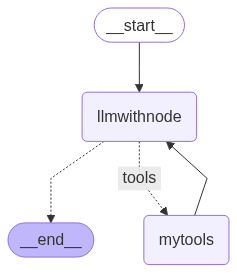

In [44]:
a2

In [48]:
config = {"configurable":{"thread_id":"1"}}

In [49]:
events = a2.stream({"messages":["What is the temperature in Delhi? Also, recommend me some good hotels to stay in Delhi for a week."]}, 
                          config = config, stream_mode="values")

In [50]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the temperature in Delhi? Also, recommend me some good hotels to stay in Delhi for a week.
================================== Ai Message ==================================
Tool Calls:
  search (gf2hab19f)
 Call ID: gf2hab19f
  Args:
    query: temperature in Delhi
================================= Tool Message =================================
Name: search

IDK
================================== Ai Message ==================================

I'm sorry, but I can't provide real-time information like the current temperature in Delhi. However, I can tell you that Delhi generally has a hot climate during the summer months (March to June) with temperatures often reaching up to 45°C (113°F), while winters (December to February) are cooler, with temperatures ranging from 10°C to 20°C (50°F to 68°F).

As for hotel recommendations, here are some popular options in Delhi for a week-long stay:

1. **Luxury H

In [52]:
config

{'configurable': {'thread_id': '1'}}

In [53]:
ms.get(config)

{'v': 3,
 'ts': '2025-06-23T08:32:22.736047+00:00',
 'id': '1f0500c9-58d0-6020-8003-5edc50975cce',
 'channel_versions': {'__start__': '00000000000000000000000000000002.0.5085765999663193',
  'messages': '00000000000000000000000000000005.0.14915502845913653',
  'branch:to:llmwithnode': '00000000000000000000000000000005.0.5000075806388761',
  'branch:to:mytools': '00000000000000000000000000000004.0.6864746648906254'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000001.0.8915354322137186'},
  'llmwithnode': {'branch:to:llmwithnode': '00000000000000000000000000000004.0.6502148165971782'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000003.0.4312192218664932'}},
 'channel_values': {'messages': [HumanMessage(content='What is the temperature in Delhi? Also, recommend me some good hotels to stay in Delhi for a week.', additional_kwargs={}, response_metadata={}, id='782b895e-4eff-4cef-adbc-8d0aa5b36527'),
   AIMessage(content='',

In [54]:
events = a2.stream({"messages":["In which city was the temperature 25degrees?"]}, 
                          config = config, stream_mode="values")

In [55]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

In which city was the temperature 25degrees?
================================== Ai Message ==================================

I'm unable to provide real-time weather data or specific information about temperatures in specific cities. However, many cities around the world experience temperatures of 25°C (77°F) during their spring, fall, or mild winter seasons. For example, cities like San Francisco, Barcelona, or Cape Town often have mild temperatures around this range during certain times of the year.

If you're looking for specific information about a city's temperature, I recommend checking a reliable weather website or app for the most accurate and up-to-date information. Let me know if you'd like help finding more general climate information!
